<a href="https://colab.research.google.com/github/kalingasajja/ML-learn/blob/main/expeiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 12.1 MB/s eta 0:00:00


In [ ]:
import mlflow
mlflow.set_tracking_uri("https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/")



In [ ]:
# Create a new experiment
mlflow.set_experiment("Exp3 max-features tuning")

<Experiment: artifact_location='file:C:/Users/kalin/mlflow_local_project/mlruns/3', creation_time=1750368498006, experiment_id='3', last_update_time=1750368498006, lifecycle_stage='active', name='Exp3 max-features tuning', tags={}>

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict,StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/reddit_preprocessing.csv").dropna(subset=['clean_comment'])
df.shape

(36793, 2)

In [ ]:
def run_experiment(vectorizer_max_features):

  ngram_range = (1,3)
  vectorizer_name = "TF-IDF"
  vectorizer = TfidfVectorizer(ngram_range=ngram_range,max_features=vectorizer_max_features)

  # Split data *after* cleaning
  X_train,X_test,y_train,y_test = train_test_split(df['clean_comment'],df['category'],test_size=0.2,random_state=42)
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)

  if mlflow.active_run():
    mlflow.end_run()

  with mlflow.start_run(nested=True) as run :
    # set tags for the experiment and run
    mlflow.set_tag("mlflow.runName",f"TF_IDF_{vectorizer_max_features}_RandomForest")
    mlflow.set_tag("experiment_type","feature_engineering")
    mlflow.set_tag("model_type","RandomForestClassifier")
    params = {
      "vectorizer_type": "TF-IDF", # Note: This parameter is hardcoded, consider making it dynamic based on vectorizer_type input
      "vectorizer_max_features": vectorizer.max_features,
      "ngram__range": ngram_range,
      "n_estimators": 200,
      "max_depth": 15
  }
  mlflow.log_params(params)

  # Initialize and train the model
  # Initialize the model
  model = RandomForestClassifier(n_estimators=params["n_estimators"],max_depth=params["max_depth"],random_state=42)
  model.fit(X_train,y_train)

  #Make predictions on the test set
  y_pred = model.predict(X_test)

  # Log metrics for each class and accuracy
  accuracy = accuracy_score(y_test,y_pred)
  mlflow.log_metric("accuracy",accuracy)
  print(f"accuracy: {accuracy}")

  classification_rep = classification_report(y_test,y_pred,output_dict=True)

  for label , metrics in classification_rep.items():
    if isinstance(metrics,dict):
       # for precision , recall , f1-score, etc.,
       for metric,value in metrics.items():

         mlflow.log_metric(f"{label}_{metric}",value)

  # confusion Matrix plot
  conf_matrix = confusion_matrix(y_test,y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues")
  plt.title(f"Confusion Matrix: {vectorizer_name}, { ngram_range}")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")

  # Save the plot to a temporary file name
  plot_filename = f"/confusion_matrix_tf_idf_{vectorizer_max_features}.png"
  plt.savefig(plot_filename)
  mlflow.log_artifact(plot_filename)

  # Log the Random Forest Model
  mlflow.sklearn.log_model(model,f"random_forest_model_tf_idf_{vectorizer_max_features}")


🏃 View run TF_IDF_1000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/3b813c8e74444b4e875dbc45f401a943
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.655252072292431


2025/06/19 21:46:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:47:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run trusting-robin-154 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/f5640a7979c54b659de0c07785876910
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
🏃 View run TF_IDF_2000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/fcaf1946c2d04ad690d0a7296d5833d4
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.6502242152466368


2025/06/19 21:47:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:48:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run puzzled-kit-203 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/11fc04a198d3472b812bf50afa2b8fb9
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
🏃 View run TF_IDF_3000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/4467603c93434caa94a8a9863206a4fa
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.6413914934094306


2025/06/19 21:48:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:49:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run shivering-fawn-524 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/988364189bad4c9b891fdb6db25c48e1
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
🏃 View run TF_IDF_4000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/de25e60772f24ad7aa845d97f975ca83
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.6366354124201657


2025/06/19 21:49:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:50:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run mercurial-bear-680 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/00a4de6c3b0f45799ab9a6c5103448b1
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
🏃 View run TF_IDF_5000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/a8950a1f0a33477da3b4e20d458f9c45
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.6378584046745481


2025/06/19 21:50:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:51:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run enthused-foal-388 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/ae623313ba254da19d3ad9b4159b31bb
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
🏃 View run TF_IDF_6000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/1e14d548624640e79212c4385ddcdf17
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.6354124201657834


2025/06/19 21:51:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:51:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run thundering-mare-834 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/23eedd3acb1f49d383cdd315edaeb436
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
🏃 View run TF_IDF_7000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/1560885475dd436c9801752958c9e1e3
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.635140644109254


2025/06/19 21:52:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:52:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ambitious-shoat-709 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/7a00eab35897403289c2d403448c1017
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
🏃 View run TF_IDF_8000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/8b87de05fd6242feb88b4684f0a5d17c
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.637450740589754


2025/06/19 21:53:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:53:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run angry-bass-331 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/b6de7e157b1c4670ba779a72e2e7178b
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
🏃 View run TF_IDF_9000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/04e41699c82349eba5ea4056440262c4
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.6389455089006658


2025/06/19 21:54:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:54:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run abundant-newt-645 at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/c5642415c22944058d57dc0f931de102
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
🏃 View run TF_IDF_10000_RandomForest at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3/runs/909dba9da5954b45baccbb6397817e8d
🧪 View experiment at: https://2339-2409-40f0-3082-72a5-d89b-81ae-7861-8dad.ngrok-free.app/#/experiments/3
accuracy: 0.634189427911401


2025/06/19 21:55:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 21:55:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


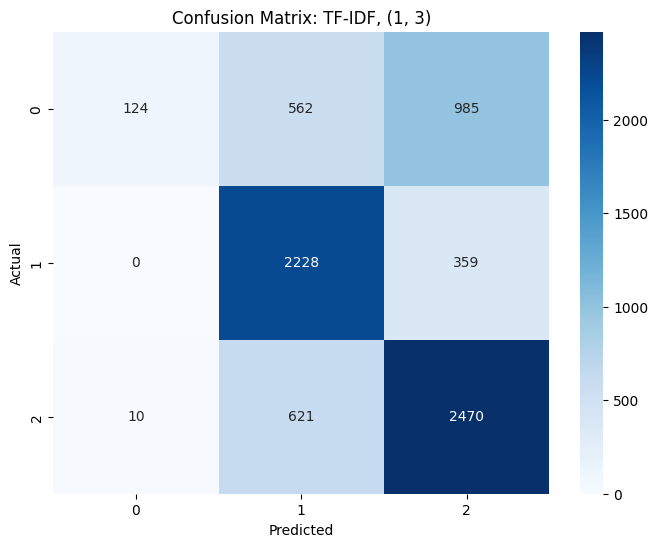

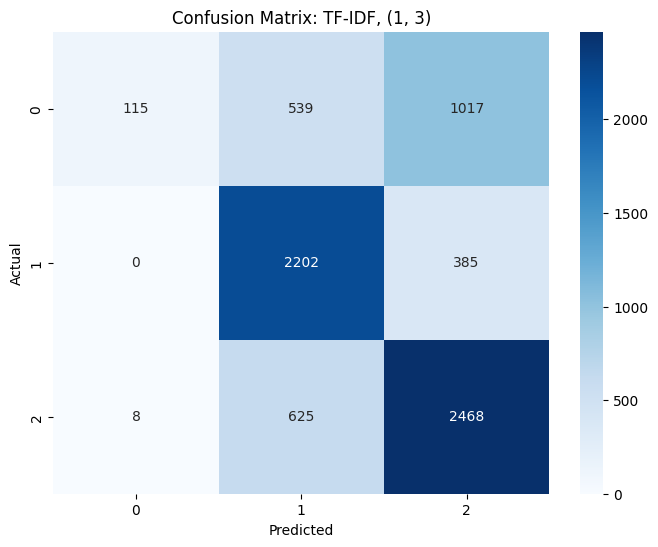

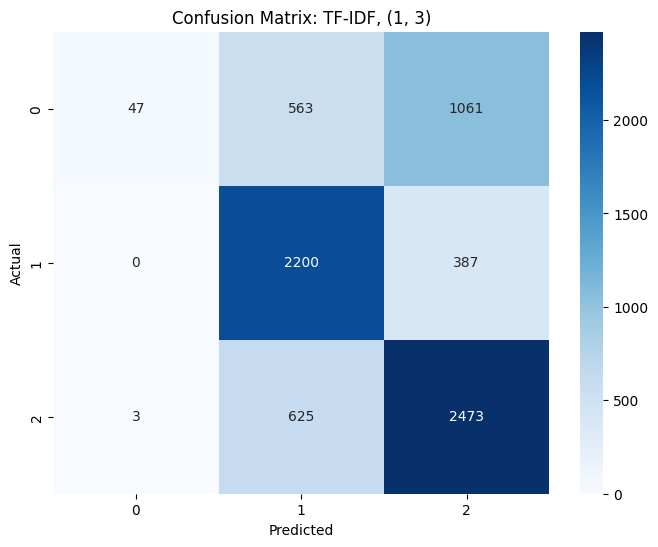

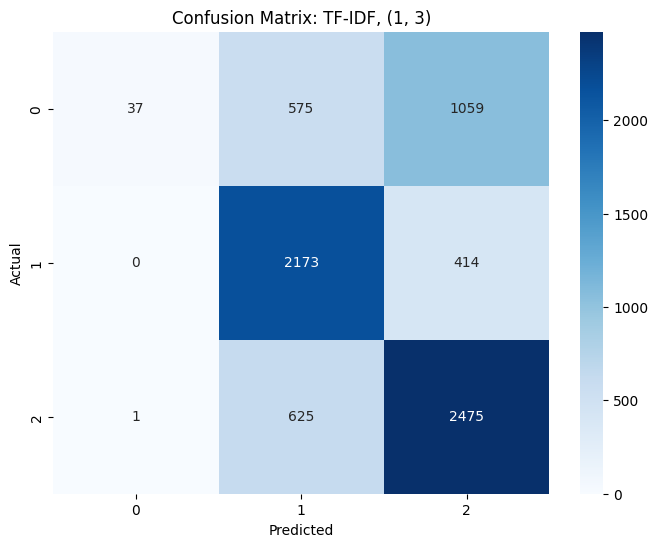

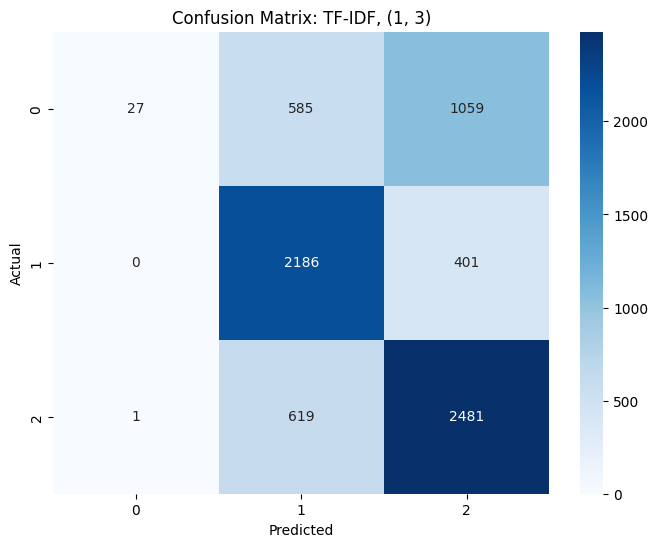

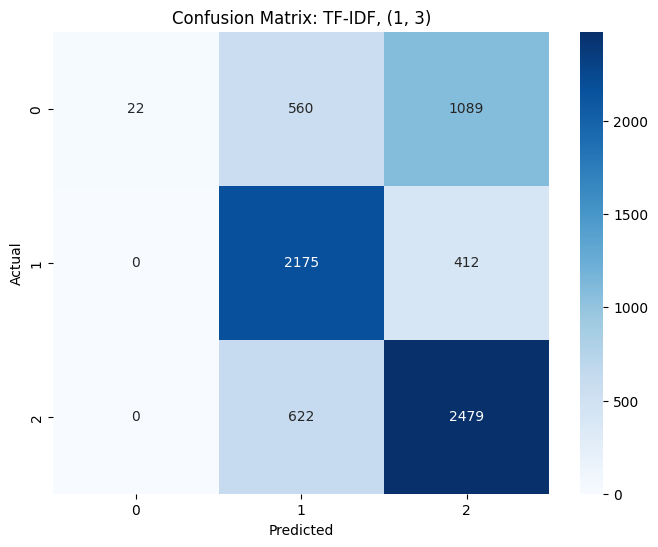

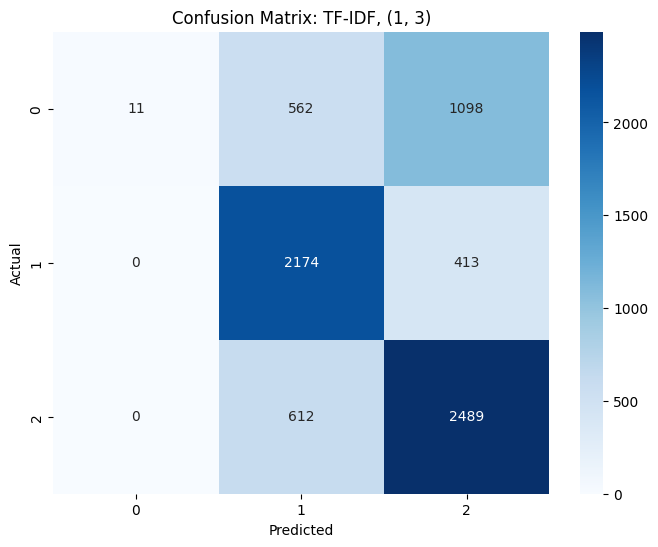

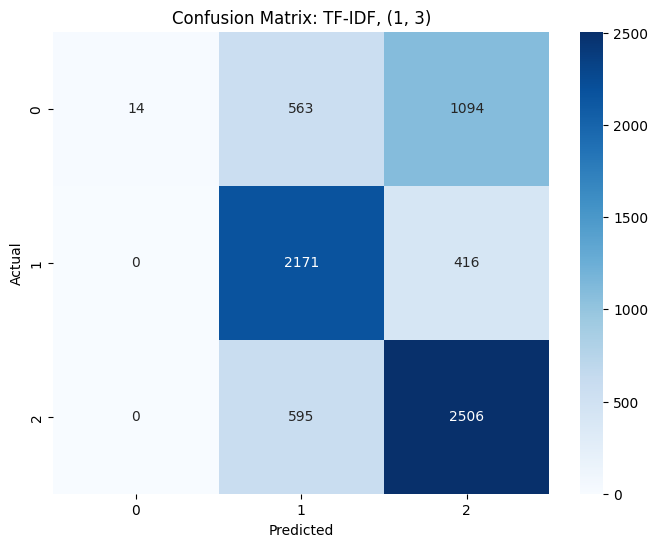

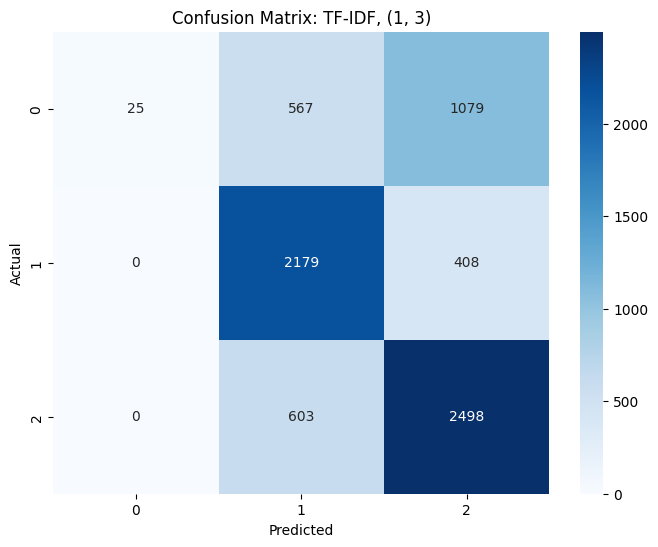

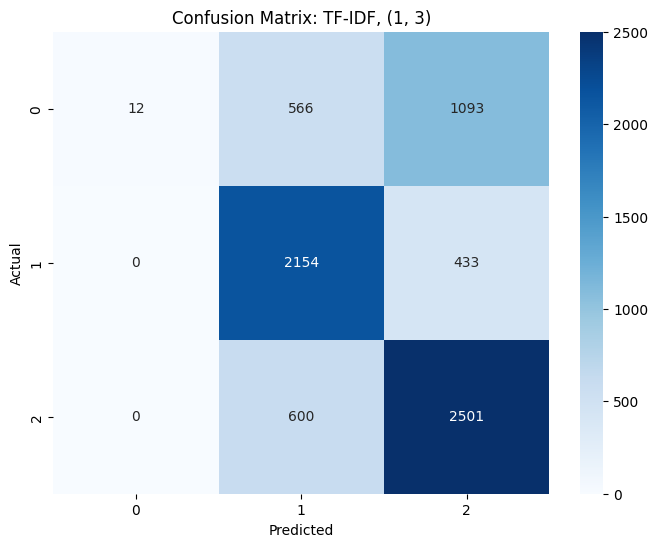

In [ ]:

max_feature_values = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
# TF-IDF experiments
for max_features in max_feature_values:
  run_experiment(max_features)
